In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import time
import datetime
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from fuzzywuzzy import process

c:\Users\YOGA PRATAMA\anaconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Membaca dataset
df = pd.read_excel('translate dataset/croatia_english_dataset.xlsx')

# Menampilkan beberapa baris pertama dari dataframe
df.head()

,english_translation
0,RT @_antens: Petrinja https://t.co/lT9GTMBs2h
1,RT @_antens: Petrinja https://t.co/lT9GTMBs2h
2,RT @_antens: Petrinja https://t.co/lT9GTMBs2h
3,RT @_antens: Petrinja https://t.co/lT9GTMBs2h
4,RT @_antens: Petrinja https://t.co/lT9GTMBs2h


In [3]:
# Inisialisasi analyzer sentimen VADER
analyzer = SentimentIntensityAnalyzer()

# Fungsi untuk mendapatkan sentimen menggunakan VADER
def vader_sentiment(text):
    return analyzer.polarity_scores(text)

# Fungsi untuk memberi label sentimen
def label_vader_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Terapkan analisis sentimen VADER
df['vader_scores'] = df['english_translation'].apply(vader_sentiment)

# Ekstrak skor individual
df['vader_compound'] = df['vader_scores'].apply(lambda x: x['compound'])
df['vader_positive'] = df['vader_scores'].apply(lambda x: x['pos'])
df['vader_negative'] = df['vader_scores'].apply(lambda x: x['neg'])
df['vader_neutral'] = df['vader_scores'].apply(lambda x: x['neu'])

# Terapkan pelabelan
df['vader_sentiment_label'] = df['vader_compound'].apply(label_vader_sentiment)

# Tampilkan dataframe yang telah diperbarui
df[['english_translation', 'vader_compound', 'vader_positive', 'vader_negative', 'vader_neutral', 'vader_sentiment_label']].head()

,english_translation,vader_compound,vader_positive,vader_negative,vader_neutral,vader_sentiment_label
0,RT @_antens: Petrinja https://t.co/lT9GTMBs2h,0.0,0.0,0.0,1.0,neutral
1,RT @_antens: Petrinja https://t.co/lT9GTMBs2h,0.0,0.0,0.0,1.0,neutral
2,RT @_antens: Petrinja https://t.co/lT9GTMBs2h,0.0,0.0,0.0,1.0,neutral
3,RT @_antens: Petrinja https://t.co/lT9GTMBs2h,0.0,0.0,0.0,1.0,neutral
4,RT @_antens: Petrinja https://t.co/lT9GTMBs2h,0.0,0.0,0.0,1.0,neutral


In [4]:
# Menghapus baris kosong
df = df.dropna()

# Mengonversi kolom kamus menjadi string untuk menghindari TypeError
df['vader_scores'] = df['vader_scores'].apply(str)

# Menghapus baris duplikat, menyimpan kejadian pertama
df = df.drop_duplicates()

# Verifikasi hasil
print(f"Jumlah baris setelah menghapus baris kosong dan duplikat: {len(df)}")
df.head()

Jumlah baris setelah menghapus baris kosong dan duplikat: 22


,english_translation,vader_scores,vader_compound,vader_positive,vader_negative,vader_neutral,vader_sentiment_label
0,RT @_antens: Petrinja https://t.co/lT9GTMBs2h,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,neutral
149,⚠️ #Croatia 🇭🇷 First images from the M6.4 eart...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,neutral
348,"Rubbled houses, images are scary, I hope it's ...","{'neg': 0.148, 'neu': 0.555, 'pos': 0.296, 'co...",0.4946,0.296,0.148,0.555,positive
386,#BreakingNews | A 6.3 magnitude earthquake occ...,"{'neg': 0.086, 'neu': 0.914, 'pos': 0.0, 'comp...",-0.1531,0.000,0.086,0.914,negative
394,🇭🇷 New 6.3 magnitude earthquake in #Petrinja #...,"{'neg': 0.151, 'neu': 0.849, 'pos': 0.0, 'comp...",-0.4939,0.000,0.151,0.849,negative


In [5]:
# Mengecek apakah ada baris yang semua kolomnya kosong
kosong = df.isnull().all(axis=1)

# Menampilkan jumlah baris yang kosong seluruhnya
print(f"Jumlah baris yang kosong seluruhnya: {kosong.sum()}")

# Menampilkan baris-baris yang kosong seluruhnya
print(df[kosong])

Jumlah baris yang kosong seluruhnya: 0
Empty DataFrame
Columns: [english_translation, vader_scores, vader_compound, vader_positive, vader_negative, vader_neutral, vader_sentiment_label]
Index: []


In [6]:
df['vader_sentiment_label'].value_counts()

vader_sentiment_label
positive    9
neutral     7
negative    6
Name: count, dtype: int64

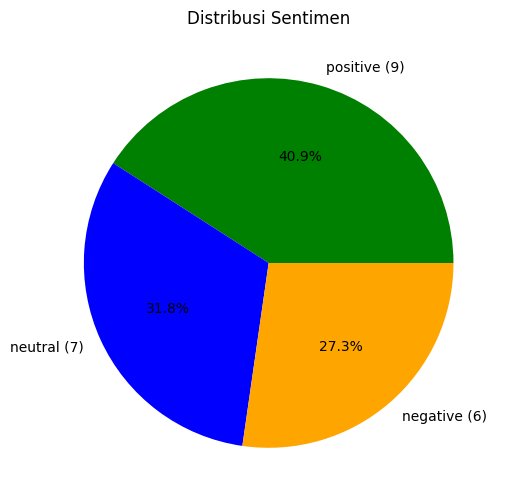

In [7]:
# Definisikan warna untuk setiap label sentimen
colors = {
    'positive': 'green',
    'negative': 'orange',
    'neutral': 'blue'
}

# Hitung jumlah nilai untuk masing-masing kelas
sentiment_counts = df['vader_sentiment_label'].value_counts()

# Set label dengan jumlah
labels = [f"{label} ({count})" for label, count in sentiment_counts.items()]

# Buat pie chart
plt.figure(figsize=(10, 6))
sentiment_counts.plot.pie(
    autopct='%1.1f%%',
    colors=[colors[label.split(' ')[0]] for label in labels],
    labels=labels
)

plt.title('Distribusi Sentimen')
plt.ylabel('')
plt.show()


In [8]:
# Daftar nama kota
city_list = [
    'sisak-moslavina', 'petrinja', 'croatia', 'zagreb', 'bosnia and herzegovina', 'czech', 'serbia'
]

# Fungsi untuk membersihkan teks
def clean_text(text):
    # Hapus mentions
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Hapus hashtags
    text = re.sub(r'#\w+', '', text)
    # Hapus retweets
    text = re.sub(r'RT[\s]+', '', text)
    # Hapus URLs
    text = re.sub(r'https?://\S+', '', text)
    # Hapus angka
    text = re.sub(r'\d+', '', text)
    # Hapus tanggal (format seperti 16aug, 16Aug, dll)
    text = re.sub(r'\d+(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)[a-z]*', '', text, flags=re.IGNORECASE)

    # Identifikasi nama kota yang mungkin salah ejaan
    words = text.split()
    for word in words:
        # Cari kecocokan terbaik dengan daftar kota
        match, score = process.extractOne(word, city_list)
        if score > 90:  # Skor kemiripan >80 dianggap cocok
            text = text.replace(word, '')  # Hapus nama kota

    # Hapus karakter non-alphanumeric kecuali spasi
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Terapkan fungsi pembersihan pada kolom 'english_translation'
df['cleaned_text'] = df['english_translation'].apply(clean_text)

# Tampilkan dataframe yang telah dibersihkan
df.head()

,english_translation,vader_scores,vader_compound,vader_positive,vader_negative,vader_neutral,vader_sentiment_label,cleaned_text
0,RT @_antens: Petrinja https://t.co/lT9GTMBs2h,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,neutral,
149,⚠️ #Croatia 🇭🇷 First images from the M6.4 eart...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,neutral,First images from the M earthquake in County c...
348,"Rubbled houses, images are scary, I hope it's ...","{'neg': 0.148, 'neu': 0.555, 'pos': 0.296, 'co...",0.4946,0.296,0.148,0.555,positive,Rubbled houses images are scary I hope its not...
386,#BreakingNews | A 6.3 magnitude earthquake occ...,"{'neg': 0.086, 'neu': 0.914, 'pos': 0.0, 'comp...",-0.1531,0.000,0.086,0.914,negative,A magnitude earthquake occurred in The earthqu...
394,🇭🇷 New 6.3 magnitude earthquake in #Petrinja #...,"{'neg': 0.151, 'neu': 0.849, 'pos': 0.0, 'comp...",-0.4939,0.000,0.151,0.849,negative,New magnitude earthquake in Unlike yesterday t...


In [9]:
# Menghapus baris duplikat berdasarkan kolom 'cleaned_text'
df = df.drop_duplicates(subset=['cleaned_text'])

# Menghapus baris dengan kolom yang kosong
df = df.dropna()

# Verifikasi hasil
print(f"Jumlah baris setelah menghapus duplikat dan kolom kosong: {len(df)}")
df.head()

Jumlah baris setelah menghapus duplikat dan kolom kosong: 18


,english_translation,vader_scores,vader_compound,vader_positive,vader_negative,vader_neutral,vader_sentiment_label,cleaned_text
0,RT @_antens: Petrinja https://t.co/lT9GTMBs2h,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,neutral,
149,⚠️ #Croatia 🇭🇷 First images from the M6.4 eart...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,neutral,First images from the M earthquake in County c...
348,"Rubbled houses, images are scary, I hope it's ...","{'neg': 0.148, 'neu': 0.555, 'pos': 0.296, 'co...",0.4946,0.296,0.148,0.555,positive,Rubbled houses images are scary I hope its not...
386,#BreakingNews | A 6.3 magnitude earthquake occ...,"{'neg': 0.086, 'neu': 0.914, 'pos': 0.0, 'comp...",-0.1531,0.000,0.086,0.914,negative,A magnitude earthquake occurred in The earthqu...
394,🇭🇷 New 6.3 magnitude earthquake in #Petrinja #...,"{'neg': 0.151, 'neu': 0.849, 'pos': 0.0, 'comp...",-0.4939,0.000,0.151,0.849,negative,New magnitude earthquake in Unlike yesterday t...


In [10]:
# Terapkan case folding pada kolom 'cleaned_text'
def apply_case_folding(df, column_name):
    df[column_name] = df[column_name].str.lower()
    return df

# Terapkan case folding pada kolom 'cleaned_text' dan simpan di kolom baru
df['case_folded_text'] = df['cleaned_text'].str.lower()

# Tampilkan dataframe yang telah diperbarui
df.head()

,english_translation,vader_scores,vader_compound,vader_positive,vader_negative,vader_neutral,vader_sentiment_label,cleaned_text,case_folded_text
0,RT @_antens: Petrinja https://t.co/lT9GTMBs2h,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,neutral,,
149,⚠️ #Croatia 🇭🇷 First images from the M6.4 eart...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,neutral,First images from the M earthquake in County c...,first images from the m earthquake in county c...
348,"Rubbled houses, images are scary, I hope it's ...","{'neg': 0.148, 'neu': 0.555, 'pos': 0.296, 'co...",0.4946,0.296,0.148,0.555,positive,Rubbled houses images are scary I hope its not...,rubbled houses images are scary i hope its not...
386,#BreakingNews | A 6.3 magnitude earthquake occ...,"{'neg': 0.086, 'neu': 0.914, 'pos': 0.0, 'comp...",-0.1531,0.000,0.086,0.914,negative,A magnitude earthquake occurred in The earthqu...,a magnitude earthquake occurred in the earthqu...
394,🇭🇷 New 6.3 magnitude earthquake in #Petrinja #...,"{'neg': 0.151, 'neu': 0.849, 'pos': 0.0, 'comp...",-0.4939,0.000,0.151,0.849,negative,New magnitude earthquake in Unlike yesterday t...,new magnitude earthquake in unlike yesterday t...


In [11]:
nltk.download('punkt')

# Fungsi untuk melakukan tokenisasi teks
def tokenize_text(text):
    return word_tokenize(text)

# Terapkan tokenisasi pada kolom 'case_folded_text' dan simpan di kolom baru
df['tokenized_text'] = df['case_folded_text'].apply(tokenize_text)

# Tampilkan dataframe yang telah diperbarui
df.head()

[nltk_data] Downloading package punkt to C:\Users\YOGA
[nltk_data]     PRATAMA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,english_translation,vader_scores,vader_compound,vader_positive,vader_negative,vader_neutral,vader_sentiment_label,cleaned_text,case_folded_text,tokenized_text
0,RT @_antens: Petrinja https://t.co/lT9GTMBs2h,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,neutral,,,[]
149,⚠️ #Croatia 🇭🇷 First images from the M6.4 eart...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,neutral,First images from the M earthquake in County c...,first images from the m earthquake in county c...,"[first, images, from, the, m, earthquake, in, ..."
348,"Rubbled houses, images are scary, I hope it's ...","{'neg': 0.148, 'neu': 0.555, 'pos': 0.296, 'co...",0.4946,0.296,0.148,0.555,positive,Rubbled houses images are scary I hope its not...,rubbled houses images are scary i hope its not...,"[rubbled, houses, images, are, scary, i, hope,..."
386,#BreakingNews | A 6.3 magnitude earthquake occ...,"{'neg': 0.086, 'neu': 0.914, 'pos': 0.0, 'comp...",-0.1531,0.000,0.086,0.914,negative,A magnitude earthquake occurred in The earthqu...,a magnitude earthquake occurred in the earthqu...,"[a, magnitude, earthquake, occurred, in, the, ..."
394,🇭🇷 New 6.3 magnitude earthquake in #Petrinja #...,"{'neg': 0.151, 'neu': 0.849, 'pos': 0.0, 'comp...",-0.4939,0.000,0.151,0.849,negative,New magnitude earthquake in Unlike yesterday t...,new magnitude earthquake in unlike yesterday t...,"[new, magnitude, earthquake, in, unlike, yeste..."


In [12]:
# Unduh stopwords
nltk.download('stopwords')

# Dapatkan daftar stopwords dalam bahasa Inggris
stop_words = set(stopwords.words('english'))

# Fungsi untuk menghapus stopwords
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Terapkan penghapusan stopwords pada kolom 'case_folded_text' dan simpan di kolom baru
df['text_without_stopwords'] = df['case_folded_text'].apply(remove_stopwords)

# Tampilkan dataframe yang telah diperbarui
df.head()

[nltk_data] Downloading package stopwords to C:\Users\YOGA
[nltk_data]     PRATAMA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,english_translation,vader_scores,vader_compound,vader_positive,vader_negative,vader_neutral,vader_sentiment_label,cleaned_text,case_folded_text,tokenized_text,text_without_stopwords
0,RT @_antens: Petrinja https://t.co/lT9GTMBs2h,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,neutral,,,[],
149,⚠️ #Croatia 🇭🇷 First images from the M6.4 eart...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,neutral,First images from the M earthquake in County c...,first images from the m earthquake in county c...,"[first, images, from, the, m, earthquake, in, ...",first images earthquake county confirm damage
348,"Rubbled houses, images are scary, I hope it's ...","{'neg': 0.148, 'neu': 0.555, 'pos': 0.296, 'co...",0.4946,0.296,0.148,0.555,positive,Rubbled houses images are scary I hope its not...,rubbled houses images are scary i hope its not...,"[rubbled, houses, images, are, scary, i, hope,...",rubbled houses images scary hope scary
386,#BreakingNews | A 6.3 magnitude earthquake occ...,"{'neg': 0.086, 'neu': 0.914, 'pos': 0.0, 'comp...",-0.1531,0.000,0.086,0.914,negative,A magnitude earthquake occurred in The earthqu...,a magnitude earthquake occurred in the earthqu...,"[a, magnitude, earthquake, occurred, in, the, ...",magnitude earthquake occurred earthquake affec...
394,🇭🇷 New 6.3 magnitude earthquake in #Petrinja #...,"{'neg': 0.151, 'neu': 0.849, 'pos': 0.0, 'comp...",-0.4939,0.000,0.151,0.849,negative,New magnitude earthquake in Unlike yesterday t...,new magnitude earthquake in unlike yesterday t...,"[new, magnitude, earthquake, in, unlike, yeste...",new magnitude earthquake unlike yesterday dama...


In [13]:
# Inisialisasi stemmer
stemmer = PorterStemmer()

# Fungsi untuk melakukan stemming pada teks
def stem_text(text):
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

# Terapkan stemming pada kolom 'text_without_stopwords' dan simpan hasilnya di kolom baru
df['stemmed_text'] = df['text_without_stopwords'].apply(stem_text)

# Tampilkan dataframe yang telah diperbarui
df.head()

,english_translation,vader_scores,vader_compound,vader_positive,vader_negative,vader_neutral,vader_sentiment_label,cleaned_text,case_folded_text,tokenized_text,text_without_stopwords,stemmed_text
0,RT @_antens: Petrinja https://t.co/lT9GTMBs2h,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,neutral,,,[],,
149,⚠️ #Croatia 🇭🇷 First images from the M6.4 eart...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,neutral,First images from the M earthquake in County c...,first images from the m earthquake in county c...,"[first, images, from, the, m, earthquake, in, ...",first images earthquake county confirm damage,first imag earthquak counti confirm damag
348,"Rubbled houses, images are scary, I hope it's ...","{'neg': 0.148, 'neu': 0.555, 'pos': 0.296, 'co...",0.4946,0.296,0.148,0.555,positive,Rubbled houses images are scary I hope its not...,rubbled houses images are scary i hope its not...,"[rubbled, houses, images, are, scary, i, hope,...",rubbled houses images scary hope scary,rubbl hous imag scari hope scari
386,#BreakingNews | A 6.3 magnitude earthquake occ...,"{'neg': 0.086, 'neu': 0.914, 'pos': 0.0, 'comp...",-0.1531,0.000,0.086,0.914,negative,A magnitude earthquake occurred in The earthqu...,a magnitude earthquake occurred in the earthqu...,"[a, magnitude, earthquake, occurred, in, the, ...",magnitude earthquake occurred earthquake affec...,magnitud earthquak occur earthquak affect capit
394,🇭🇷 New 6.3 magnitude earthquake in #Petrinja #...,"{'neg': 0.151, 'neu': 0.849, 'pos': 0.0, 'comp...",-0.4939,0.000,0.151,0.849,negative,New magnitude earthquake in Unlike yesterday t...,new magnitude earthquake in unlike yesterday t...,"[new, magnitude, earthquake, in, unlike, yeste...",new magnitude earthquake unlike yesterday dama...,new magnitud earthquak unlik yesterday damag e...


In [14]:
# Tampilkan 5 baris pertama dari kolom yang ditentukan
df[['cleaned_text', 'case_folded_text', 'tokenized_text', 'text_without_stopwords', 'stemmed_text']].head()


,cleaned_text,case_folded_text,tokenized_text,text_without_stopwords,stemmed_text
0,,,[],,
149,First images from the M earthquake in County c...,first images from the m earthquake in county c...,"[first, images, from, the, m, earthquake, in, ...",first images earthquake county confirm damage,first imag earthquak counti confirm damag
348,Rubbled houses images are scary I hope its not...,rubbled houses images are scary i hope its not...,"[rubbled, houses, images, are, scary, i, hope,...",rubbled houses images scary hope scary,rubbl hous imag scari hope scari
386,A magnitude earthquake occurred in The earthqu...,a magnitude earthquake occurred in the earthqu...,"[a, magnitude, earthquake, occurred, in, the, ...",magnitude earthquake occurred earthquake affec...,magnitud earthquak occur earthquak affect capit
394,New magnitude earthquake in Unlike yesterday t...,new magnitude earthquake in unlike yesterday t...,"[new, magnitude, earthquake, in, unlike, yeste...",new magnitude earthquake unlike yesterday dama...,new magnitud earthquak unlik yesterday damag e...


In [15]:
# Tambahkan fitur tambahan
df['text_length'] = df['english_translation'].apply(len)
df['word_count'] = df['english_translation'].apply(lambda x: len(x.split()))

In [16]:
# Data sampel
documents = df['stemmed_text'].tolist()

# Inisialisasi TF-IDF Vectorizer dengan parameter yang ditentukan
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 1), min_df=3)

# Fit dan transformasi data teks
X_tfidf = tfidf_vectorizer.fit_transform(documents)

# Dapatkan nama fitur
feature_names = tfidf_vectorizer.get_feature_names_out()

# Hitung TF (Term Frequency)
tf = np.array(X_tfidf.toarray())

# Konversi ke DataFrame untuk keterbacaan yang lebih baik
tf_df = pd.DataFrame(tf, columns=feature_names)

# Tampilkan hasil
print("TF (Term Frequency):")
print(tf_df.head())

TF (Term Frequency):
     affect     damag  earthquak      imag  magnitud  strong
0  0.000000  0.000000   0.000000  0.000000  0.000000     0.0
1  0.000000  0.701234   0.400084  0.590088  0.000000     0.0
2  0.000000  0.000000   0.000000  1.000000  0.000000     0.0
3  0.594062  0.000000   0.677877  0.000000  0.433097     0.0
4  0.000000  0.733823   0.418678  0.000000  0.534989     0.0


In [17]:
# Hitung TF Normalisasi
tf_sum = tf.sum(axis=1, keepdims=True)
tf_sum[tf_sum == 0] = 1  # Hindari pembagian dengan nol
tf_normalized = tf / tf_sum

# Konversi ke DataFrame untuk keterbacaan yang lebih baik
tf_normalized_df = pd.DataFrame(tf_normalized, columns=feature_names)

# Tampilkan hasil
print("\nTF Normalisasi:")
print(tf_normalized_df.head())


TF Normalisasi:
     affect     damag  earthquak      imag  magnitud  strong
0  0.000000  0.000000   0.000000  0.000000  0.000000     0.0
1  0.000000  0.414586   0.236539  0.348874  0.000000     0.0
2  0.000000  0.000000   0.000000  1.000000  0.000000     0.0
3  0.348416  0.000000   0.397573  0.000000  0.254010     0.0
4  0.000000  0.434861   0.248107  0.000000  0.317032     0.0


In [18]:
# Hitung IDF (Inverse Document Frequency)
idf = np.log((1 + len(documents)) / (1 + (tf > 0).sum(axis=0))) + 1

# Konversi ke DataFrame untuk keterbacaan yang lebih baik
idf_df = pd.DataFrame(idf, index=feature_names, columns=["IDF"])

# Tampilkan hasil
print("\nIDF (Inverse Document Frequency):")
print(idf_df.head())


IDF (Inverse Document Frequency):
                IDF
affect     2.558145
damag      2.558145
earthquak  1.459532
imag       2.152680
magnitud   1.864997


In [19]:
# Hitung TF-IDF Normalisasi
tfidf_normalized = tf_normalized * idf

# Konversi ke DataFrame untuk keterbacaan yang lebih baik
tfidf_normalized_df = pd.DataFrame(tfidf_normalized, columns=feature_names)

# Tampilkan hasil
print("\nTF-IDF Normalisasi:")
print(tfidf_normalized_df.head())


TF-IDF Normalisasi:
     affect     damag  earthquak      imag  magnitud  strong
0  0.000000  0.000000   0.000000  0.000000  0.000000     0.0
1  0.000000  1.060571   0.345237  0.751015  0.000000     0.0
2  0.000000  0.000000   0.000000  2.152680  0.000000     0.0
3  0.891299  0.000000   0.580271  0.000000  0.473729     0.0
4  0.000000  1.112437   0.362120  0.000000  0.591264     0.0


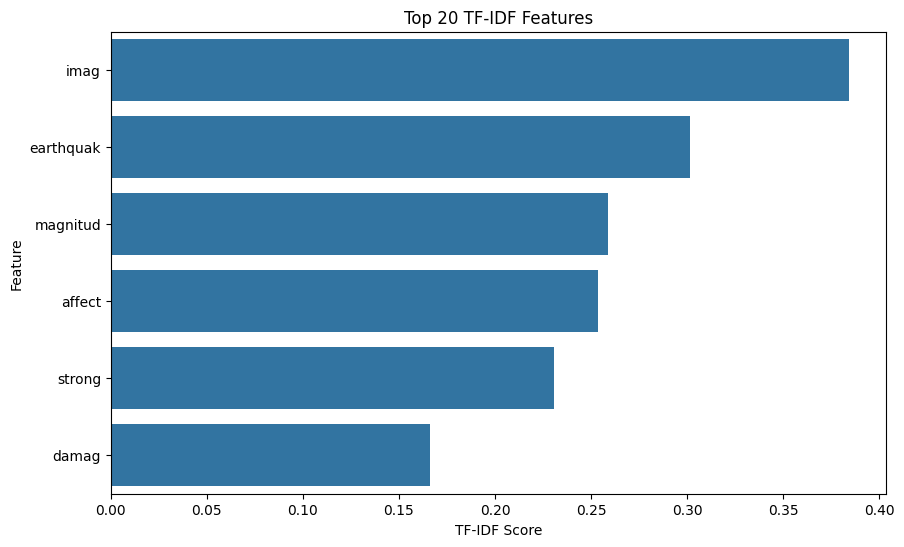

In [20]:
# Tampilkan 20 fitur TF-IDF teratas
top_n = 20
# Kecualikan kolom non-numerik
numeric_tfidf_df = tfidf_normalized_df.select_dtypes(include=[np.number])
tfidf_means = numeric_tfidf_df.mean().sort_values(ascending=False)[:top_n]

plt.figure(figsize=(10, 6))
sns.barplot(x=tfidf_means.values, y=tfidf_means.index)
plt.title('Top 20 TF-IDF Features')
plt.xlabel('TF-IDF Score')
plt.ylabel('Feature')
plt.show()


===== SVM with linear kernel =====
===== K-Fold Cross Validation Results =====

Fold 1:
Training time: 0:00:00.002002
Accuracy: 0.5000

Fold 2:
Training time: 0:00:00.002475
Accuracy: 0.7500

Fold 3:
Training time: 0:00:00.002007
Accuracy: 0.5000

Fold 4:
Training time: 0:00:00.002502
Accuracy: 0.3333

Fold 5:
Training time: 0:00:00.001998
Accuracy: 0.6667

===== Overall Model Performance =====
Mean Accuracy: 0.5500
Standard Deviation: 0.1453
Average Training Time: 0:00:00.002197

===== Combined Performance Metrics =====
Overall Accuracy: 0.5556
Overall Precision: 0.5972
Overall Recall: 0.5556
Overall F1 Score: 0.5651
Overall Error Rate: 0.4444

Combined Confusion Matrix:
[[3 3 0]
 [1 3 2]
 [0 2 4]]

Combined Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.50      0.60         6
     neutral       0.38      0.50      0.43         6
    positive       0.67      0.67      0.67         6

    accuracy                           

<Figure size 800x600 with 0 Axes>

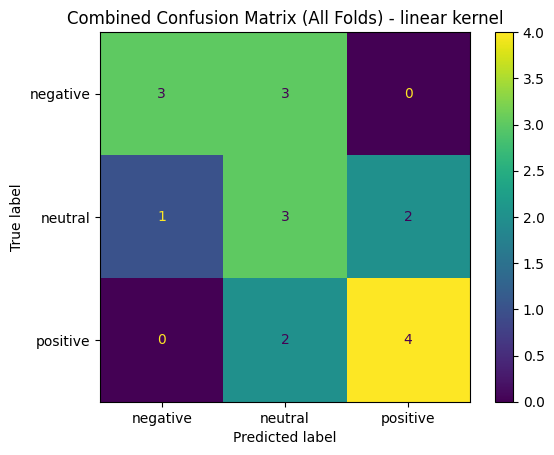


===== SVM with poly kernel =====
===== K-Fold Cross Validation Results =====

Fold 1:
Training time: 0:00:00.001013
Accuracy: 0.5000

Fold 2:
Training time: 0:00:00.002805
Accuracy: 0.7500

Fold 3:
Training time: 0:00:00.000996
Accuracy: 1.0000

Fold 4:
Training time: 0:00:00.001000
Accuracy: 0.6667

Fold 5:
Training time: 0:00:00.000999
Accuracy: 0.3333

===== Overall Model Performance =====
Mean Accuracy: 0.6500
Standard Deviation: 0.2261
Average Training Time: 0:00:00.001362

===== Combined Performance Metrics =====
Overall Accuracy: 0.6667
Overall Precision: 0.6714
Overall Recall: 0.6667
Overall F1 Score: 0.6655
Overall Error Rate: 0.3333

Combined Confusion Matrix:
[[4 2 0]
 [1 3 2]
 [0 1 5]]

Combined Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.67      0.73         6
     neutral       0.50      0.50      0.50         6
    positive       0.71      0.83      0.77         6

    accuracy                           0.

<Figure size 800x600 with 0 Axes>

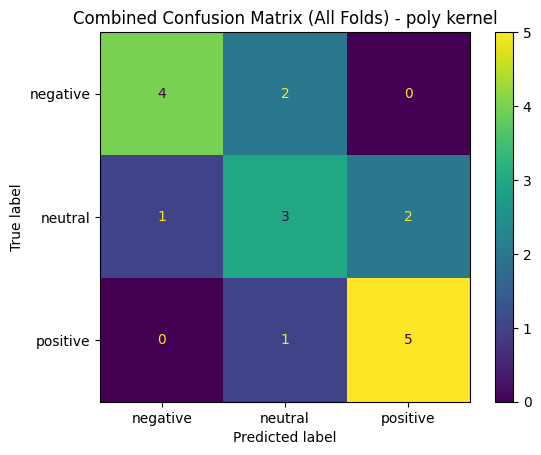


===== SVM with rbf kernel =====
===== K-Fold Cross Validation Results =====

Fold 1:
Training time: 0:00:00.002020
Accuracy: 0.5000

Fold 2:
Training time: 0:00:00.001995
Accuracy: 0.7500

Fold 3:
Training time: 0:00:00.001000
Accuracy: 0.7500

Fold 4:
Training time: 0:00:00.000998
Accuracy: 0.6667

Fold 5:
Training time: 0:00:00.001003
Accuracy: 0.6667

===== Overall Model Performance =====
Mean Accuracy: 0.6667
Standard Deviation: 0.0913
Average Training Time: 0:00:00.001403

===== Combined Performance Metrics =====
Overall Accuracy: 0.6667
Overall Precision: 0.6944
Overall Recall: 0.6667
Overall F1 Score: 0.6683
Overall Error Rate: 0.3333

Combined Confusion Matrix:
[[3 3 0]
 [1 4 1]
 [0 1 5]]

Combined Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.50      0.60         6
     neutral       0.50      0.67      0.57         6
    positive       0.83      0.83      0.83         6

    accuracy                           0.6

<Figure size 800x600 with 0 Axes>

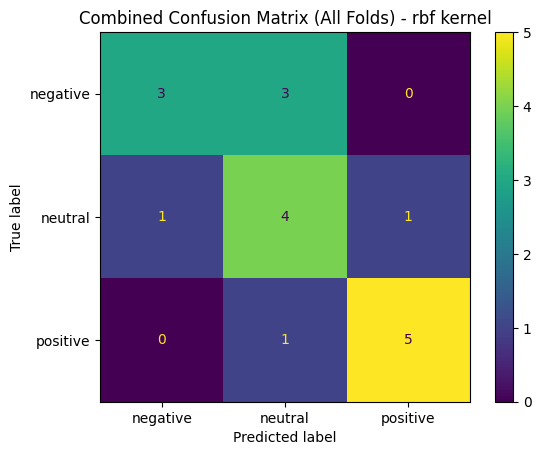


===== SVM with sigmoid kernel =====
===== K-Fold Cross Validation Results =====

Fold 1:
Training time: 0:00:00.001003
Accuracy: 0.7500

Fold 2:
Training time: 0:00:00.000998
Accuracy: 0.0000

Fold 3:
Training time: 0:00:00.001024
Accuracy: 0.5000

Fold 4:
Training time: 0:00:00
Accuracy: 0.3333

Fold 5:
Training time: 0:00:00.000992
Accuracy: 0.3333

===== Overall Model Performance =====
Mean Accuracy: 0.3833
Standard Deviation: 0.2449
Average Training Time: 0:00:00.000803

===== Combined Performance Metrics =====
Overall Accuracy: 0.3889
Overall Precision: 0.5503
Overall Recall: 0.3889
Overall F1 Score: 0.4094
Overall Error Rate: 0.6111

Combined Confusion Matrix:
[[2 4 0]
 [0 2 4]
 [0 3 3]]

Combined Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.33      0.50         6
     neutral       0.22      0.33      0.27         6
    positive       0.43      0.50      0.46         6

    accuracy                           0.39  

<Figure size 800x600 with 0 Axes>

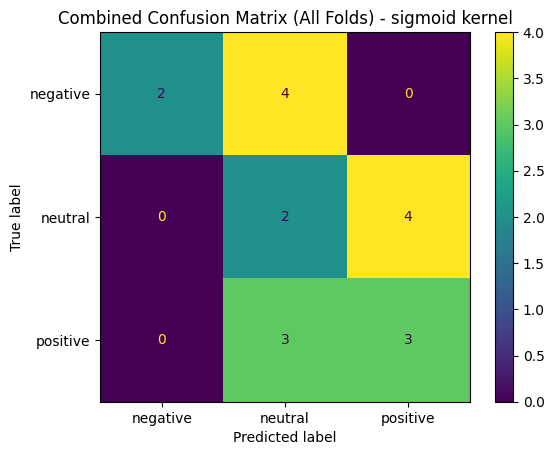

In [60]:
def svm_analysis(X_np, y_np):
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    results = {}

    for kernel in kernels:
        print(f"\n===== SVM with {kernel} kernel =====")
        print("===== K-Fold Cross Validation Results =====")
        kfold = KFold(n_splits=5, shuffle=True)
        classes = np.unique(y_np)
        
        # Inisialisasi daftar untuk menyimpan hasil dari semua lipatan
        all_predictions = []
        all_true_values = []
        fold_accuracies = []
        training_times = []
        
        for i, (train_idx, test_idx) in enumerate(kfold.split(X_np)):
            X_train_fold, X_test_fold = X_np[train_idx], X_np[test_idx]
            y_train_fold, y_test_fold = y_np[train_idx], y_np[test_idx]
            
            # Latih model
            model = SVC(kernel=kernel, class_weight='balanced')
            start_time = time.time()
            model.fit(X_train_fold, y_train_fold)
            end_time = time.time()
            training_time = end_time - start_time
            training_times.append(training_time)
            
            # Buat prediksi
            y_pred = model.predict(X_test_fold)
            acc = accuracy_score(y_test_fold, y_pred)
            fold_accuracies.append(acc)
            
            # Simpan prediksi dan nilai sebenarnya untuk analisis gabungan
            all_predictions.extend(y_pred)
            all_true_values.extend(y_test_fold)
            
            print(f"\nFold {i+1}:")
            print(f"Training time: {str(datetime.timedelta(seconds=training_time))}")
            print(f"Accuracy: {acc:.4f}")
        
        # Hitung statistik
        mean_accuracy = np.mean(fold_accuracies)
        std_accuracy = np.std(fold_accuracies)
        mean_training_time = np.mean(training_times)
        
        print("\n===== Overall Model Performance =====")
        print(f"Mean Accuracy: {mean_accuracy:.4f}")
        print(f"Standard Deviation: {std_accuracy:.4f}")
        print(f"Average Training Time: {str(datetime.timedelta(seconds=mean_training_time))}")
        
        # Hitung metrik gabungan
        cm_combined = confusion_matrix(all_true_values, all_predictions, labels=classes)
        
        # Hitung performa metrik keseluruhan
        accuracy = accuracy_score(all_true_values, all_predictions)
        precision = precision_score(all_true_values, all_predictions, average='weighted', zero_division=0)
        recall = recall_score(all_true_values, all_predictions, average='weighted', zero_division=0)
        f1 = f1_score(all_true_values, all_predictions, average='weighted', zero_division=0)
        
        print("\n===== Combined Performance Metrics =====")
        print(f"Overall Accuracy: {accuracy:.4f}")
        print(f"Overall Precision: {precision:.4f}")
        print(f"Overall Recall: {recall:.4f}")
        print(f"Overall F1 Score: {f1:.4f}")
        print(f"Overall Error Rate: {1 - accuracy:.4f}")
        
        print("\nCombined Confusion Matrix:")
        print(cm_combined)
        print("\nCombined Classification Report:")
        print(classification_report(all_true_values, all_predictions, zero_division=0))

        # Plot confusion matrix gabungan
        plt.figure(figsize=(8,6))
        ConfusionMatrixDisplay(confusion_matrix=cm_combined, display_labels=classes).plot()
        plt.title(f"Combined Confusion Matrix (All Folds) - {kernel} kernel")
        plt.show()
        
        # Simpan hasil untuk setiap kernel
        results[kernel] = {
            'fold_accuracies': fold_accuracies,
            'mean_accuracy': mean_accuracy,
            'std_accuracy': std_accuracy,
            'mean_training_time': mean_training_time,
            'confusion_matrix': cm_combined,
            'classification_report': classification_report(all_true_values, all_predictions, zero_division=0, output_dict=True)
        }
    
    return results

# Konversi matriks sparse ke format dense
X_np = X_tfidf.toarray()
y_np = df['vader_sentiment_label'].values

# Jalankan analisis
results = svm_analysis(X_np, y_np)


===== linear kernel =====
Standard Deviation: 0.1453


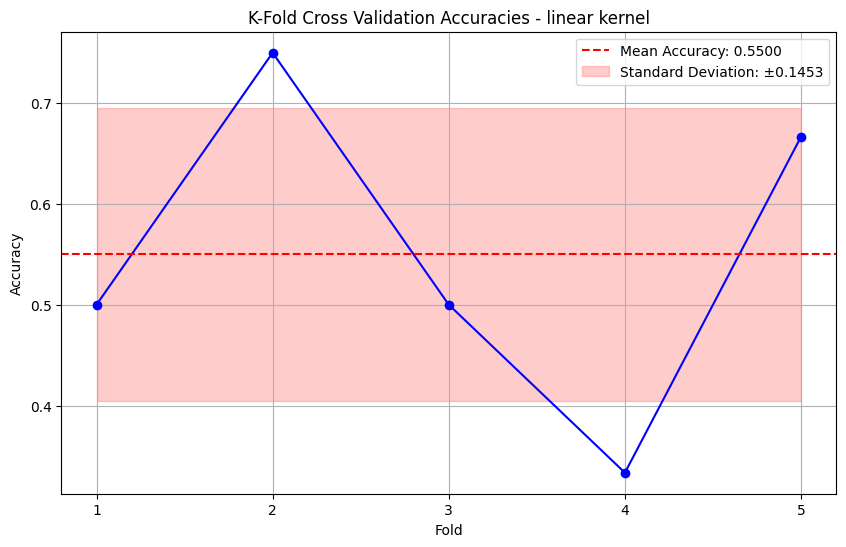


===== poly kernel =====
Standard Deviation: 0.2261


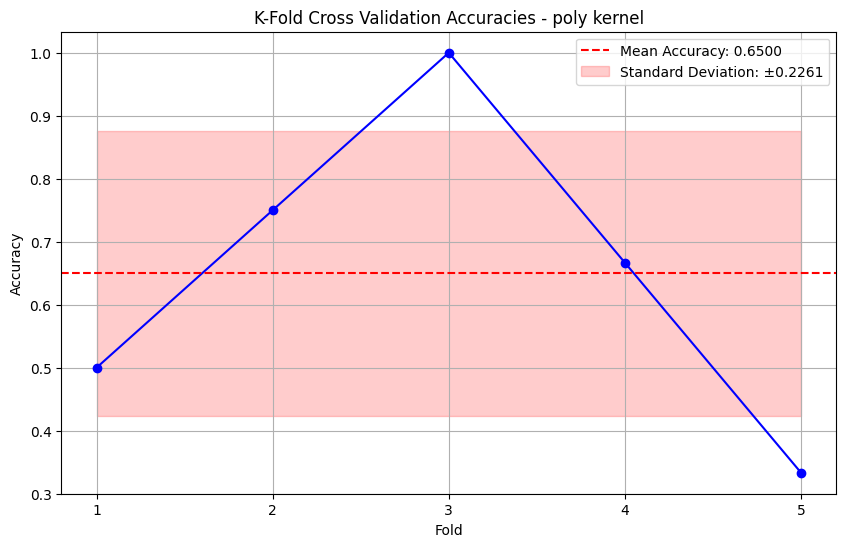


===== rbf kernel =====
Standard Deviation: 0.0913


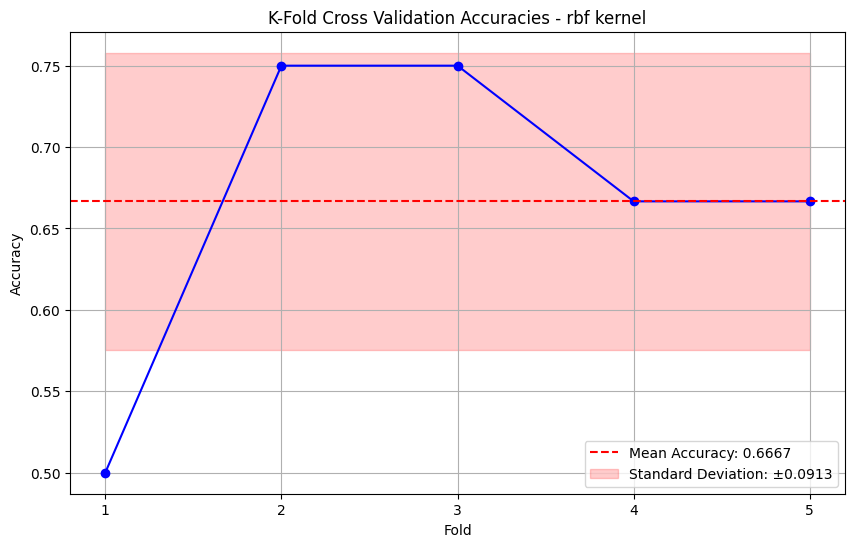


===== sigmoid kernel =====
Standard Deviation: 0.2449


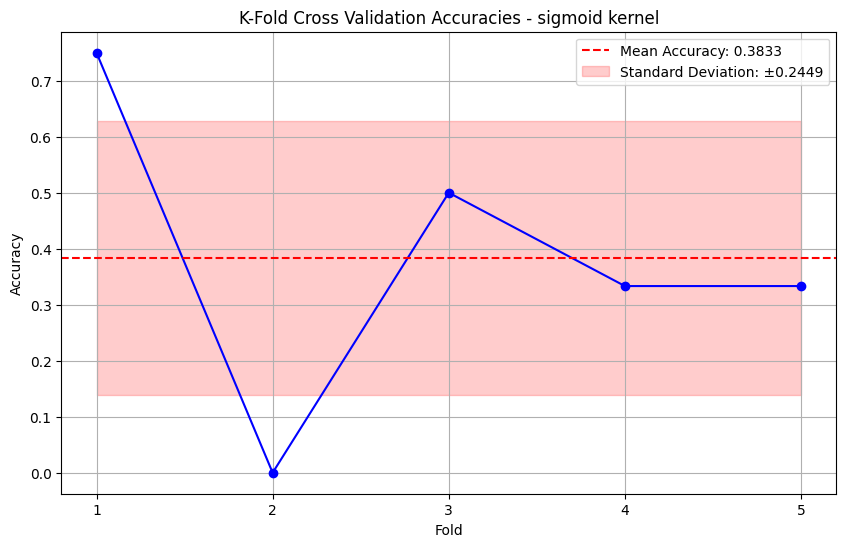

In [61]:
def plot_accuracies(results):
    for kernel, result in results.items():
        fold_accuracies = result['fold_accuracies']
        mean_accuracy = result['mean_accuracy']
        std_accuracy = result['std_accuracy']
        
        # Visualisasikan 5 akurasi
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(fold_accuracies) + 1), fold_accuracies, marker='o', linestyle='-', color='b')
        plt.title(f'K-Fold Cross Validation Accuracies - {kernel} kernel')
        plt.xlabel('Fold')
        plt.ylabel('Accuracy')
        plt.xticks(range(1, len(fold_accuracies) + 1))
        plt.grid(True)

        # Tampilkan standar deviasi
        print(f"\n===== {kernel} kernel =====")
        print(f"Standard Deviation: {std_accuracy:.4f}")

        # Tambahkan rata-rata akurasi ke plot
        plt.axhline(y=mean_accuracy, color='r', linestyle='--', label=f'Mean Accuracy: {mean_accuracy:.4f}')

        # Tambahkan standar deviasi ke plot
        plt.fill_between(range(1, len(fold_accuracies) + 1), mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, color='r', alpha=0.2, label=f'Standard Deviation: ±{std_accuracy:.4f}')

        # Tambahkan legenda ke plot
        plt.legend()

        # Tampilkan plot
        plt.show()

plot_accuracies(results)


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, 0 to 824
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   english_translation     18 non-null     object 
 1   vader_scores            18 non-null     object 
 2   vader_compound          18 non-null     float64
 3   vader_positive          18 non-null     float64
 4   vader_negative          18 non-null     float64
 5   vader_neutral           18 non-null     float64
 6   vader_sentiment_label   18 non-null     object 
 7   cleaned_text            18 non-null     object 
 8   case_folded_text        18 non-null     object 
 9   tokenized_text          18 non-null     object 
 10  text_without_stopwords  18 non-null     object 
 11  stemmed_text            18 non-null     object 
 12  text_length             18 non-null     int64  
 13  word_count              18 non-null     int64  
dtypes: float64(4), int64(2), object(8)
memory usage:

In [62]:
# Simpan DataFrame ke file Excel
df.to_excel('hasil analisis/hasil_sentiment_analysis_croatia_vader.xlsx', index=False)

# Konfirmasi bahwa file telah disimpan
print("DataFrame has been saved to 'hasil_sentiment_analysis_croatia_vader.xlsx'")

DataFrame has been saved to 'hasil_sentiment_analysis_croatia_vader.xlsx'
